In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random as rand
from sklearn import datasets, linear_model
import copy as cp
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from mpl_toolkits.mplot3d import Axes3D

import numpy.random as randn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.linear_model import Lasso

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.offline as py

# Régression Probabiliste et Bayesienne

## Rappel 

La **régression** est un processus d'apprentissage supervisé qui consiste à construire un modèle prédictif à partir de données quantitatives.

On considère une observation $X$ (pouvant être vectoriel) et une sortie $y$ scalaire ici (mais pouvant être vectoriel) tel que

$$
y=f(X)+ \epsilon
$$

avec une fonction (transformation) inconnue et $\epsilon =\mathcal{N}(0,\sigma^2)$ un bruit sur les données.

**But**: $\color{red}{\text{approcher $f$ à partir d'un jeu d'apprentissage $((X_1,y_1),....,(X_n,y_n))$}}$.

**Modèle linéaire**:

On se donne une fonction $f_{\theta}$ du type:

si $X=(x_1,...x_d)$ est un vecteur en taille $d$
$$
f_{\theta}(X)=\sum_{i=1}^d \omega_i x_i + b
$$

Pour déterminer les paramètres, on souhaite résoudre le problème aux moindres carrés

$$
\operatorname{min}_{\theta}J(\theta)=\sum_{i=1}^n \parallel y_i-f_{\theta}(x_i)\parallel_2^2
$$

Cela revient à chercher l'hyperplan qui approche au mieux l'ensemble des données.

**Rappel théorique**:

On cherche le minimum avec résolvant l'équation $\nabla J(\theta)=0$. Cette équation est équivalente à l'équation normale.

Trois cas:

- Si $d+1<n$ avec $d+1$ le nombre de paramètres: matrice de l'équation normale inversible donc **unicité du gradient**.
- Si $d+1=n$ avec $d+1$ le nombre de paramètres: matrice de l'équation normale inversible donc **unicité du gradient** et l'hyperplan passe exactement par les points (interpolation).
- Si $d+1>n$ avec $d+1$ le nombre de paramètres: matrice de l'équation normale non inversible donc **non unicité du gradient**.

Dans le dernier cas il y a une $\color{red}{\text{infinité d'hyperplan solution du problème}}$. On a donc plein de solutions qui seront $\color{red}{\text{très mauvaise lorsqu'on généralise à d'autre données}}$. On parle de **sur-apprentissage**.

**Solution**: le modèle est trop libre d'où le sur-apprentissage. Idée on rajoute des contraintes: $\leq \lambda$

**Contrainte faible**:

$$
\operatorname{min}_{\theta}J(\theta)=\sum_{i=1}^n \parallel y_i-f_{\theta}(x_i)\parallel_2^2 +\parallel\theta \parallel_{?}
$$

On parle de régularisation **Ridge** pour $R(\theta)=\parallel \theta\parallel_2^2$ et **Lasso** pour  $R(\theta)=\parallel \theta\parallel_1$.
- La régularisation **Ridge** pousse les poids à être petit.
- La régularisation **Lasso** pousse les poids à être nuls.

On avait vu que le sur-apprentissage venait d'une perte d'unicité de la solution du problème de minimisation.
**Que se passe t'il ici ?**

On reprend l'exemple précédent avec la descente de gradient:

In [2]:
def droite_loss(x):
    return 0.5*x+3.5


def data2(nb_point,bruit):
    
    x_train = np.random.uniform(-1.0,1.0,nb_point)
    eps = np.random.normal(0.0,bruit,nb_point)
    y_train = droite_loss(x_train)+eps

    return x_train,y_train

def loss2(reg,omega,b,x_train,y_train):
    J=0.0
    J_w=0.0
    J_b=0.0
    n= np.shape(x_train)[0]
    for i in range(0,n):
        J=J+ (y_train[i]-omega*x_train[i]-b)**2.0 + reg*omega**2.0 + reg*b**2.0
        J_w =J_w- x_train[i]*(y_train[i]-omega*x_train[i]-b) + reg*2.0*omega
        J_b=J_b-(y_train[i]-omega*x_train[i]-b) + reg*2.0*b
    return J/n,J_w/n,J_b/n

In [5]:
def plot_gradient2(nb_point,bruit,eta,ig,reg):
    n=100
    np.random.seed(50)
    xt,yt=data2(nb_point,bruit)
    xtt=xt.reshape(-1,1)
    ridge = Ridge(alpha=reg,tol=10-10).fit(xtt,yt)
    
    tw = np.linspace(-30.0,30,n)
    tb = np.linspace(-4.0,12.0,n)
    
    tw_mg,tb_mg=np.meshgrid(tw,tb)
    J_mg= loss2(reg,tw_mg,tb_mg,xt,yt)[0]
    w0= [tw[90]]
    b0= [tb[90]]
    l0 =[loss2(reg,w0[-1],b0[-1],xt,yt)[0]]
    
    Jmin=loss2(reg,ridge.coef_,ridge.intercept_,xt,yt)[0]

    for i in range(0,ig):
        wc=w0[-1]
        bc=b0[-1]
        w0.append(wc-eta*loss2(reg,wc,bc,xt,yt)[1])
        b0.append(bc-eta*loss2(reg,wc,bc,xt,yt)[2])
        l0.append(loss2(reg,w0[-1],b0[-1],xt,yt)[0])
    
    fig = go.Figure()
    fig.add_trace(go.Surface(x=tw_mg, y=tb_mg, z=J_mg, cmid=0, colorscale="Jet",opacity=0.5))
    fig.add_trace(go.Scatter3d(x=[0.5], y=[3.5], z=[0.0],mode='markers',marker_size=5,marker_color='red'))
    fig.add_trace(go.Scatter3d(x=ridge.coef_, y=[ridge.intercept_], z=[Jmin[0]],mode='markers',marker_size=8,marker_color='blue',opacity=0.75))
    fig.add_trace(go.Scatter3d(x=w0, y=b0, z=l0, marker_color="green",opacity=0.9,marker_size=4))
    fig.update_layout(height=500, width=800, margin=dict(l=35, r=30, b=45, t=60),showlegend=False)
    fig.show()

In [6]:
@interact(nb_point=(1,20,1),bruit=(0.02,0.05,0.005),eta=(0.2,2.0,0.1),ig=(0,100,5),reg=(0.0,1.0,0.01))
def plot9(nb_point=10,bruit=0.05,eta=0.1,ig=0,reg=0):
    plot_gradient2(nb_point,bruit,eta,ig,reg)

interactive(children=(IntSlider(value=10, description='nb_point', max=20, min=1), FloatSlider(value=0.05, desc…

## Régression linéaire probabiliste

**Idée centrale**: on modélise le bruit dans le modèle. 

On ne cherche plus $f(x)$ tel que $y=f(x)+\epsilon$ mais on cherche une **probabilité**

$$
p_{\theta}(y\mid x)= \mathcal{N}((\omega,x)+b,\sigma^2)
$$

avec $\theta=(\omega,b)$.

On ne cherche plus une fonction mais une $\color{red}{\text{loi de probabilité}}$. Ici on suppose que la loi de probabilité est **Gaussienne** de moyenne linéaire par rapport à x et de variance le bruit supposé.

**Construction du modèle**:

On ne cherche plus a **fitter** une fonction mais une loi de probabilité. On ne va donc pas construire le modèle en minimisant la distance avec les données.

Comment détermine t'on les paramètres d'une loi de probabilité ? Par un $\color{red}{\text{estimateur statistique}}$.

**Lequel ?** $\color{red}{\text{l'estimateur par maximum de vraissemblance}}$.

**Vraisemblance**: la vraisemblance quantifie $\color{red}{\text{la probabilité que les observations proviennent effectivement d'un échantillon}}$ (théorique) de la loi $p_{\theta}(.)$. 

Soit $\mathcal{X}=\left\{x_1,\ldots,x_n\right\}$ un échantillon, $p_{\theta}(.)$ une famille de lois de probabilité paramétrique. On appelle vraisemblance associée à la famille $p_{\theta}(.)$ la fonction:

$$
\displaystyle L(x_1,\ldots,x_n,\theta) = \prod_{i=1}^n p_{\theta}(x_i) 
$$


**Interprétation dans le cas continu**:

$$
\mathbb{P}\left[ X_1\in \mathcal{B}(x_1,\epsilon)], ... ,X_n\in \mathcal{B}(x_n,\epsilon)  \right] = \prod_{i=1}^n \int_{x_i-\frac{\epsilon}{2}}^{x_i+\frac{\epsilon}{2}}f_{\theta}(x)dx
$$

$$
\mathbb{P}\left[ X_1\in \mathcal{B}(x_1,\epsilon)], ... ,X_n\in \mathcal{B}(x_n,\epsilon)  \right] \approx f_{\theta}(x_i)\epsilon^n =\epsilon^n L(x_1,\ldots,x_n,\theta)
$$

Les probabilités ponctuelles sont nulles. Cependant avec ce calcul on voit qu'on peut directement relier la probabilité que nos variables aléatoires soit dans un voisinage des échantillons avec **la vraisemblance**.

**Maximiser la vraisemblance** revient donc à maximiser $\mathbb{P}\left[ X_1\in \mathcal{B}(x_1,\epsilon)], ... ,X_n\in \mathcal{B}(x_n,\epsilon)  \right]$ et donc $\color{red}{\text{revient a maximiser la probabilité que $p_{\theta}$ génère des données dans le voisinage des échantillons}}$.

**Estimateur de maximum de vraisemblance**: solution de 

$$
\theta^*=\operatorname{argmax}_{\theta}L(x_1,\ldots,x_n,\theta)
$$

On revient à notre modèle:

$$
p_{\theta}(y\mid x)= \mathcal{N}((\omega,x)+b,\sigma^2)
$$

On veut donc maximiser:

$$
\operatorname{argmax}_{\theta}\mathcal{L}(y_1,\ldots,y_n\mid x_1,..,.x_n,\theta)=\prod_{i=1}^n p_{\theta}(y_i \mid x_i) 
$$

Le produit est compliquée à optimiser. On résout donc $\color{red}{\text{le log vraisemblance}}$.

$$
\operatorname{argmax}_{\theta} log \left(\mathcal{L}(y_1,\ldots,y_n\mid x_1,..,.x_n,\theta) \right)= \sum_{i=1}^n log (p_{\theta}(y_i \mid x_i))
$$

$$
\mathcal{L}_{log}(y_1,....y_n,\mid x_1,..,.x_n,\theta)=\sum_{i=1}^n \operatorname{log} \mathcal{N}(y_i \mid (\omega,x_i) + b,\sigma^2)
$$

ce qui donne

$$
\mathcal{L}_{log}(y_1,....y_n,\mid x_1,..,.x_n,\theta)=-  \frac{1}{2\sigma^2}\sum_{i=1}^n ((\omega,x_i) + b -y_i)^2 + \frac{N}{2} \operatorname{ln} (\sigma^{-2}) - \frac{N}{2} \operatorname{ln} (2\pi)
$$

Maximiser cette fonction revient à minimiser: 

$$
\frac{1}{2\sigma^2}\sum_{i=1}^n ((\omega,x_i) + b -y_i)^2
$$

On retrouve $\color{red}{\text{la régression au sens des moindres carrés}}$. Il y a donc équivalence.

## Régression linéaire par MAP

On va maintenant introduire une variante.

Elle est basée sur des outils de $\color{red}{\text{statistique Bayesienne}}$ mais on ne parle pas encore de **régression Bayesienne**. 

L'idée centrale est $\color{red}{\text{de ce donner un a-priori sur les poids $\theta$ }}$.

- On appelle la **distribution à priori**:

$$
p(\theta \mid \alpha)
$$

avec $\alpha$ les **hyperparamètres**. Cela correspond à note croyance a priori sur les poids $\theta$.
- On appelle la **vraissemblance marginale**:

$$
p(\mathcal{Y} \mid \mathcal{X}, \alpha) = \int_{\theta} p(\mathcal{Y} \mid  \mathcal{X},\theta)p(\theta \mid \alpha) d\theta
$$

si on a des données observées et cibles.
- On appelle la **distribution à posteriori**:

$$
p(\theta \mid \mathcal{X},\mathcal{Y}, \alpha) = \frac{p(\mathcal{Y}\mid \mathcal{X},\theta,\alpha)p(\theta \mid \alpha)}{p(\mathcal{Y}\mid, \mathcal{X}, \alpha)} 
$$

On veut voir cette distribution comme la mise à jour de notre croyance au vu des données.

- On appelle la **distribution à posteriori prédictive**:

$$
p(y \mid \mathcal{Y}, x, \mathcal{X}, \alpha) = \int p(y\mid x, \theta)p(\theta \mid \mathcal{Y}, \mathcal{X},\alpha) d \theta
$$

On peut voir comme une moyenne sur l'ensemble des modèles pondérées par la probabilité des modèles connaissant les données.

**Formule de Bayes**:

$$
p(A\mid B)p(B)=p(B \mid A)p(A)\quad \rightarrow p(\theta \mid \mathcal{X},\mathcal{Y}, \alpha)p(\mathcal{Y} \mid \mathcal{X}, \alpha)=p(\mathcal{Y} \mid  \mathcal{X},\theta)p(\theta \mid \alpha)
$$

**1ère idée**:
Maintenant on va introduire la généralisation de l'estimateur du maximum de vraisemblance dans ce cadre Bayesien. On parle d'$\color{red}{\text{estimateur du maximum a posteriori}}$.

Soit $(y_1,...,y_n)$ et $(x_1,...x_n)$ un échantillon de vraisemblance: 

$$
\mathcal{L}( y_1,...y_n \mid, x_1,...,x_n,\theta)
$$

On appelle **estimateur du maximum a posteriori** la solution de 

$$
\hat{\theta}_{map}=\operatorname{argmax}_{\theta} \mathcal{L}(\theta \mid y_1,...y_n, x_1,...,x_n, \alpha)= \operatorname{argmax}_{\theta} \mathcal{L}( y_1,...y_n \mid, x_1,...,x_n, \theta, \alpha)p(\theta \mid \alpha)
$$

avec $p(\theta \mid \alpha)$ $\color{red}{\text{distribution a priori}}$. On a utilisé que la vraisemblance marginale ne dépend pas de $\theta$.

On voit que dans le cadre **Bayesien** le maximum de vraisemblance revient à maximiser la **distribution d'échantillonnage** alors que **l'estimateur MAP** maximise la **distribution à posteriori**. Les deux approches sont identiques lorsqu'on considère que $p(\theta\mid \alpha)$ est une loi uniforme.

**Application à la régression linéaire**

$$
p_{\theta}(y \mid x)=\mathcal{N}((\omega,x) + b,\sigma^2)
$$

On fait l'hypothèse de distribution à priori:

$$
p(\theta \mid \alpha) = \mathcal{N}(0,\frac{1}{\alpha})
$$

Cela revient à supposer que $\color{red}{\text{les poids sont principalement concentrés autour de zéro}}$.

On résout 
$$
\operatorname{argmax}_{\theta} \mathcal{L}( y_1,...,y_n \mid x_1,..., x_n, \theta, \alpha)p(\theta \mid \alpha)
$$

Cela revient donc à maximiser

$$
\mathcal{L}(y_1,...,y_n \mid x_1,..., x_n, \theta, \alpha)p(\theta \mid \alpha)=\left(\Pi_{i=1}^n \mathcal{N}(y_i \mid (\omega,x_i) + b,\sigma^2)\right)\mathcal{N}(0,\frac{1}{\alpha})
$$

Résoudre ce problème revient donc au final à minimiser la fonctionnelle:

$$
\mathcal{J}(\theta)=  \frac{1}{2}\sum_{i=1}^n ((\omega,x_i) + b -y_i)^2 + \frac{\sigma^2\alpha}{2}\left(( \omega,\omega) + b^2\right)
$$

On retrouve un problème classique de **régularisation Ridge** qui a une unique solution. On voit que $\alpha>>1$ ce qui correspond à une très petite variance dans la loi à priori et donc à des poids très faibles, on retombe sur un coefficient régularisation important ce qui génère des poids très faibles.

Si on prend comme loi à priori 

$$
p(\theta \mid \alpha) = \mathcal{L_a}\left(0,\frac{1}{\alpha}\right)
$$

avec $\mathcal{L_a}$ une loi de Laplace, on retrouve $\color{red}{\text{la régression Lasso}}$.

## Régression linéaire Bayesienne complète

L'**idée centrale** de la $\color{red}{\text{régression Bayesienne}}$ est ne pas considérer un seul jeu de paramètres. En effet, plusieurs jeux de paramètres peuvent donner une probabilité à posteriori élevée. Il serait donc intéressant de construire directement une famille de paramètres (et donc une famille de modèle) plutôt que le meilleur jeu de paramètres.

**Principe**: $\color{red}{\text{au lieu de choisir $\theta$ qui maximise la loi de probabilité à posteriori on construit une loi des $\theta$}}$. On va tenir compte de notre incertitude sur $\theta$.

On se donne:
- Loi a priori $p(\theta \mid \alpha) = \mathcal{N}\left(0,\frac{1}{\alpha}\right)$
- Loi d'échantillonnage:

$$
p_{\theta}(y \mid x, \theta)=\mathcal{N}((\omega,x) + b,\sigma^2)
$$

et donc

$$
p_{\theta}(\mathcal{Y} \mid \mathcal{X}, \theta, b)=\Pi_{i=1}^n\mathcal{N}(y_i\mid (\theta,x_i) + b,\sigma^2)
$$


**Objectif**: $\color{red}{\text{est de calculer la loi à posteriori}}$.

**Résultats**:

La loi à posteriori est donnée par

$$
p(\theta \mid \mathcal{Y}, \mathcal{X})=\mathcal{N}(\mu_{pos},\Sigma_{pos})
$$ 

de paramètre

$$
\mu_{pos} = \frac{b_x^t}{\alpha}\left(\frac{A_x A_x^t}{\alpha}+\sigma^2 I_d\right)^{-1}b_y
$$

et 

$$
\Sigma_{pos} = \frac{I_d}{\alpha} - \frac{A_x^t}{\alpha^2}\left(\frac{A_x A_x^t}{\alpha}+\sigma^2 I_d\right)^{-1}A_x
$$

$A_x \in \mathcal{M}_{n,d+1}(\mathbb{R})$ la matrice des données observables avec une colonne en plus composée d'un $1$ et $b_y\in \mathbb{R}^{n}$.

**Preuve**:

Preuve basée sur les vecteurs Gaussiens. 

On remarque que les lois d'échantillonnage et à priori sont Gaussiennes. On écrit le vecteur aléatoire

$$
z=\left(\begin{array}{c} \theta  \\ y \end{array}\right)
$$

avec $\theta= (\omega, b)^t$ les paramètres du modèle linéaire. On peut écrire ce vecteur aléatoire sous la forme

$$
\left(\begin{array}{c} \theta  \\ y \end{array}\right) = \left(\begin{array}{cc} I_d  &  0\\  A_x & I_d \end{array}\right)\left(\begin{array}{c} \theta  \\ \epsilon \end{array}\right)
$$

Par hypothèse $\epsilon$ et $\theta$ sont Gaussiens donc le vecteur des deux est aussi Gaussien. Ensuite on applique une transformation linéaire qui préserve le caractère Gaussien. En utilisant la loi d'une transformation linéaire d'un vecteur Gaussien on obtient que

$$
\mathbb{E}[z]= \left(\begin{array}{c} \mathbb{E}[\theta]  \\ \mathbb{E}[y] \end{array}\right)= \left(\begin{array}{c} \mathbb{E}[\theta]  \\ \mathbb{E}[A_x \theta + \epsilon] \end{array}\right)= \left(\begin{array}{c} \mathbb{E}[\theta]  \\ A_x\mathbb{E}[\theta] + \mathbb{E}[\epsilon] \end{array}\right)= \left(\begin{array}{c} 0 \\ 0\end{array}\right)
$$

et 

$$
\Sigma_z=  \left(\begin{array}{cc} \operatorname{cov}(\theta,\theta) & \operatorname{cov}(\theta,A_x \theta+\epsilon) \\
\operatorname{cov}(A_x\theta+\epsilon,\theta) & \operatorname{cov}(A_x\theta+\epsilon,A_x\theta+\epsilon)  \end{array}\right)
$$

Puisqu'on sait que les paramètres $\theta$ suivent une Gausssienne $\mathcal{N}(0,\frac{1}{\alpha})$ ($\color{red}{\text{loi à priori}}$) on à

$$
 \operatorname{cov}(\theta,\theta) =\frac{1}{\alpha} I_d
$$

On passe ensuite au terme

$$
\operatorname{cov}(A_x\theta+\epsilon) = \operatorname{cov}(\theta,A_x\theta)+\operatorname{cov}(\theta,\epsilon)=  \operatorname{cov}(\theta,A_x\theta)
$$

car le bruit est indépendant des paramètres du modèle. Puisque la covariance est une application bilinéaire  on a

$$
\operatorname{cov}(\theta,A_x\theta+\epsilon) = \operatorname{cov}(\theta,A_x\theta) = \frac{A_x^t}{\alpha}
$$

Le troisième terme est le transposé. Il faut maintenant estimer le dernier terme:

$$
\operatorname{cov}(A_x\theta+\epsilon,A_x\theta+\epsilon)=  \operatorname{Var}(A_x\theta) + \operatorname{Var}(\epsilon) = \frac{A_x A_x^t}{\alpha} + \sigma^2I_d
$$

On a donc la matrice final de covariance pour la loi jointe

$$
\Sigma_z=  \frac{1}{\alpha}\left(\begin{array}{cc} I_d & A_x^t \\
A_x & A_xA_x^t +\alpha\sigma^2 I_d  \end{array}\right)
$$

avec $x_1$ le vecteur $x$ augmenter d'un $1$.

On conclut en appliquant la formule qui permet à partir de la densité jointe de construire la densité conditionnelle pour un vecteur Gaussien.

Maintenant que la loi à posteriori et donc notre modèle est construit on souhaitera faire une prédiction. 

Pour faire une prédiction il faut calculer la **loi à postériori de prédiction**:
    
$$
p(y \mid \mathcal{Y}, x, \mathcal{X}, \alpha) = \int p(y\mid x, \theta)p(\theta \mid \mathcal{Y},\mathcal{X},\alpha) d \theta
$$

Pour le modèle de régression linéaire Bayésien la loi à postériori de prédiction est donné par

$$
p(y \mid \mathcal{Y}, x, \mathcal{X}, \alpha)=\mathcal{N}(\mu_{pre},\Sigma_{pre})
$$

avec $\mu_{pre}=(\mu_{pos}, x)$ et

$$
\Sigma_{pre} = (x,\Sigma_{pos} x) +\sigma^2
$$


En général pour la prédiction on prend la moyenne de la $\color{red}{\text{loi à postériori de prédiction}}$ et la variance nous permet de construire des intervalles de confiance pour nos modèles. On peut evidemment échantionner directement la loi. On peut calculer: 

$$
\mu_{pos}^t= \left(\frac{A_x^t A_x}{\alpha}+\sigma^2 I_d\right)^{-t} \frac{b_x}{\alpha} b_y
$$

On voit que l'on retrouve la solution de la régression Ridge déterministe de paramètre $\lambda=\sigma^2\alpha$. Par conséquent on voit que la $\color{red}{\text{régression Bayesienne}}$ donne $\color{red}{\text{en moyenne la régression Ridge}}$ mais nous donne accès à la $\color{red}{\text{variance de l'estimateur}}$.

**Conclusion**:

Contrairement au MAP qui un modèle qui maximise la **loi à posteriori** (Cela revient à maximiser la vraisemblance avec un à priori), ici on construit la loi complète des paramètres.

Avantage:
- accès a la variance et donc à un $\color{red}{\text{intervalle de confiance sur le modèle}}$,
- on peut sélectionner un jeu de paramètres qui n'est pas le meilleur mais qui $\color{red}{\text{limite le sur-apprentissage}}$.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import copy as cp
from sklearn.linear_model import BayesianRidge

def func(x): return np.sin(0.5*np.pi*x)

In [13]:
# #############################################################################
# Generate sinusoidal data with noise
size1 = 10
rng = np.random.RandomState(1234)
x_train1 = np.random.uniform(0., 1., size1)
y_train1 = func(x_train1) + rng.normal(scale=0.2, size=size1)

size2 = 20
rng = np.random.RandomState(1234)
x_train2 = np.random.uniform(0., 1., size2)
y_train2 = func(x_train2) + rng.normal(scale=0.05, size=size2)

size3 = 50
rng = np.random.RandomState(1234)
x_train3 = np.random.uniform(0., 1., size3)
y_train3 = func(x_train3) + rng.normal(scale=0.01, size=size3)

x_test = np.linspace(0., 1., 100)

X_train1 = cp.copy(x_train1)
X_train2 = cp.copy(x_train2)
X_train3 = cp.copy(x_train3)
X_test = cp.copy(x_test)

X_train1.shape =(size1,1) 
X_train2.shape =(size2,1) 
X_train3.shape =(size3,1) 
X_test.shape =(100,1) 
list_trainX = [X_train1,X_train2,X_train3]
list_target = [y_train1,y_train2,y_train3]

In [14]:
def plot_regBayesien():
    reg = BayesianRidge(tol=1e-6, fit_intercept=False, compute_score=True)
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    for ax, train, target in zip(axes, list_trainX, list_target):
        reg.set_params(alpha_init=1.0, lambda_init=0.001)
        reg.fit(train,target)
        ymean, ystd = reg.predict(X_test, return_std=True)

        ax.plot(X_test[:,0], func(X_test[:,0]), color="blue", label="sin($2\\pi x$)")
        ax.scatter(train[:,0], target[:], s=50, alpha=0.5, label="observation")
        ax.plot(x_test, ymean, color="red", label="predict mean")
        ax.fill_between(X_test[:,0], ymean-ystd, ymean+ystd,
                    color="pink", alpha=0.5, label="predict std")
        ax.set_ylim(-1.5, 1.5)
        ax.legend()
    
    plt.tight_layout()
    plt.show()

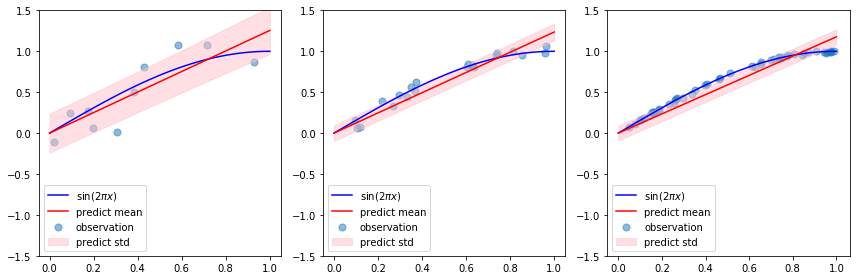

In [15]:
plot_regBayesien()

## Hierarchie de modèle

- **Maximum de Vraisemblance**:

$$
\theta^*=\operatorname{argmax}p(\mathcal{Y}\mid \mathcal{X},\theta)
$$

On cherche les paramètres qui maximisent la vraisemblance de l'échantillon.

- **Maximum à posteriori**:

$$
\theta^*=\operatorname{argmax}p(\mathcal{Y}\mid \mathcal{X},\theta)p(\theta\mid \alpha)
$$

On cherche les paramètres qui maximisent la vraisemblance de l'échantillon avec un a priori sur les poids (d'hyper paramètre $\alpha$).

- **Maximum de Vraisemblance II (Bayes empirique)**:

$$
\alpha^*=\operatorname{argmax}_{\alpha}\int_{\Theta}p(\mathcal{Y}\mid \mathcal{X},\theta)p(\theta\mid \alpha)d \theta
$$

On cherche les hyper-paramètres qui maximisent la vraisemblance de l'échantillon

- **Maximum à posteriori II**:

$$
\alpha^*=\operatorname{argmax}_{\alpha}\int_{\Theta}p(\mathcal{Y}\mid \mathcal{X},\theta)p(\theta\mid \alpha)p(\alpha)d\theta
$$

On cherche les hyper-paramètres qui maximisent la vraisemblance de l'échantillon avec un a priori sur les hyper-paramètres.

- **Full Bayes**:

$$
p(\theta,\alpha,\mid \mathcal{Y}, \mathcal{X})=p(\mathcal{Y}\mid \mathcal{X},\theta)p(\theta\mid \alpha)p(\alpha)
$$

On cherche la loi sur les paramètres/hyper-paramètres.